## Import Statements

In [ ]:
%%capture
%pip install git+https://github.com/zykls/folktables.git@12358d1645d09904b4b05e8459042e39a0d50382

In [2]:
%load_ext autoreload
%autoreload 2

from matplotlib import gridspec, rc
from matplotlib import ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import copy
from numpy.random.mtrand import beta
from sklearn.preprocessing import normalize

import folktables
from subpop import *
from learner_utils import *

%matplotlib inline

np.set_printoptions(precision=3, suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import matplotlib.colors as mcolors

def adjust_color(color, amount=1.0):
    """
    Lightens the given color when amount is in [0, 1).
    Darkens the given color when amount > 1.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> adjust_color('g', 0.3)  # Lighten
    >> adjust_color('#F034A3', 1.5)  # Darken
    >> adjust_color((.3,.55,.1), 2)  # Darken
    """
    try:
        c = mcolors.cnames[color]
    except:
        c = color
    c = np.array(mcolors.to_rgb(c))
    
    if amount < 1:  # Lighten
        c += (1-c) * abs(amount)
    else:  # Darken
        c -= c * (amount-1)
    
    return c

In [4]:
## Plotting settings
rc('text', usetex = False)
rc('font', family = 'serif')
TITLE_SIZE = 13
LABEL_SIZE = 11
LEGEND_TITLE_SIZE = 12
LEGEND_SIZE = 11
TICK_SIZE = 11
FONT = 'serif'
params = {}
params['legend.title_fontsize'] = LEGEND_TITLE_SIZE
params['axes.labelsize'] = LABEL_SIZE
params['axes.titlesize'] = TITLE_SIZE
params['legend.fontsize'] = LEGEND_SIZE
params["xtick.labelsize"]= TICK_SIZE
params["ytick.labelsize"] = TICK_SIZE
params["font.family"] = "Times New Roman"
context = sns.plotting_context("paper", rc=params)
sns.set_theme(style="whitegrid", font=FONT)

## Dynamics Simulation

In [5]:
def run_experiment(T, subpops, rr=False, min_fn=quadratic_min, early_stop=False, verbose = True, sample_size = None, temp=0.1):
    n_learners = len(subpops[0].alphas)
    if verbose:
        print("Initial Conditions:")
        print(f"There are {n_learners} initial learners")
        print(f"Subpopulation splits: {[s.beta for s in subpops]}")
        print(f"Initial allocations: {[s.alphas for s in subpops]}")
        print(f"Optimal decisions theta for each subpop (row-wise) {[s.phi for s in subpops]}")
    average_risks_subpop = []
    average_risks_learner = []
    all_risks = []
    all_thetas = []
    all_alphas = []
    thetas = np.zeros((n_learners, len(subpops[0].phi)))
    for t in range(T):
        for subpop in subpops:
            condition1 = (subpop.kind == 'sampled_shared') and sample_size is not None
            condition2 = (subpop.kind == 'sampled')
            if condition1 or condition2:
                subpop.sample(sample_size)
        if rr and t>0:
            learner = t%n_learners
            theta_learner = np.array(learner_decisions(subpops, current=learner, current_thetas=thetas, min_fn=min_fn))
            thetas[learner] = theta_learner
            thetas = copy.deepcopy(thetas)
            all_thetas.append(thetas)
        else:
            thetas = np.array(learner_decisions(subpops, current_thetas=thetas, min_fn=min_fn))
        alpha = subpop_decisions(thetas, subpops, epsilon=temp)
        all_thetas.append(thetas)
        all_alphas.append(alpha.T)
        risks = get_all_risks(thetas, subpops)
        all_risks.append(risks)
        a_risk_subpop = average_risk_subpop(thetas, subpops)
        average_risks_subpop.append(a_risk_subpop)
        a_risk_learner = average_risk_learner(thetas, subpops)
        average_risks_learner.append(a_risk_learner)
        if early_stop:
            c_counts = convergent_count(subpops)
            if min(c_counts) > 20:
                break
    if verbose:
        print("Final Conditions:")
        print(f'\t\tLearners decisions: {thetas}')
        print(f'\t\tSubpopulation allocations: {alpha}')
    return(average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas) 

## Figure 1: Risk profiles over time

In [6]:
def plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, 
                    plot_subpop = [0], plot_learners = [0],
                    ls= '-', lw=2, color_adj = 1,  legend = False, special_c= None):
    
    n_learners, n_subpops = all_risks[0].shape
    if special_c is None:
        c = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
            'tab:brown','tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
    else:
        c = [special_c]*(n_learners+n_subpops)
    for subpop in plot_subpop:
        # Average Losses of the subpops
        color = adjust_color(c[subpop], color_adj)
        axs[0].plot([a[subpop] for a in average_risks_subpop], color = color, ls= ls, lw=lw,label = f"Subpop {subpop + 1}")
        axs[0].set_xlabel('Time t')
        axs[0].set_ylabel('Risk')
        axs[0].set_title('Subpopulation 1 risk')
        if legend:
            axs[0].legend()


    for learner in plot_learners:     
        # Learner Risks
        color = adjust_color(c[learner], color_adj)
        axs[1].plot([a[learner] for a in average_risks_learner], color = color, ls= ls, lw=lw , label = f"Learner {learner + 1}")
        axs[1].set_xlabel('Time t')
        axs[1].set_ylabel('')
        axs[1].set_title('Learner 2 risk')
        if legend:
            axs[1].legend()
    
    total_risk = [np.sum(round_risks) for round_risks in all_risks]
    color = adjust_color('k', color_adj)
    if special_c is not None:
        color = special_c
    axs[2].plot(total_risk, ls= ls, lw=lw+1, c = color)
    axs[2].set_xlabel('Time t')
    axs[2].set_ylabel('')
    axs[2].set_title('Total risk')
    #axs[1].legend()
    

In [7]:
def run_trial(allocation=None, min_fn = quadratic_min, sample_size = None, k = 100000, T=500, temp=0.1, shared_sample = True):
    # relative sizes
    beta_1 = 1
    beta_2 = 1 
    beta_3 = 1
    # initial allocations
    if allocation is  None:
        dist = np.array([[0.01, 0.02, -0.04], [-0.01,-0.01, 0.02]])
        dist = np.random.rand(2,3)*0.1
        alpha = np.array([[1,1, 1], [1,1, 1]]) + dist
        # alpha_ij <- fraction of subpop j going to learner i
        alpha =  normalize(alpha, axis=0, norm='l1')   
    else:
        alpha = allocation
    # optimal thetas for each subpop
    phi_1 = np.array([0, 1])
    phi_2 = np.array([1, 1])
    phi_3 = np.array([0.6, 0])
    # phi = np.array([phi_1, phi_2])
    
    
    if k is None:
        pop1 = QuadraticSubPop(phi_1, beta_1, alpha[:,0])
        pop2 = QuadraticSubPop(phi_2, beta_2, alpha[:,1])
        pop3 = QuadraticSubPop(phi_3, beta_3, alpha[:,2])
    
    else:
        pop1_xs = np.random.normal(size=(k, 2))
        pop1_ys = pop1_xs@phi_1 + np.random.normal(size=k)*1
        
        pop2_xs = np.random.normal(size=(k, 2))
        pop2_ys = pop2_xs@phi_2 + np.random.normal(size=k)*1
        
        pop3_xs = np.random.normal(size=(k, 2))
        pop3_ys = pop3_xs@phi_3 + np.random.normal(size=k)*1
        
        if shared_sample:
            pop1 = SampledSubPop(pop1_xs, pop1_ys, beta_1, alpha[:,0])
            pop2 = SampledSubPop(pop2_xs, pop2_ys, beta_2, alpha[:,1])
            pop3 = SampledSubPop(pop3_xs, pop3_ys, beta_3, alpha[:,2])
        else:
            pop1 = SampledMultinomialSubPop(pop1_xs, pop1_ys, beta_1, alpha[:,0])
            pop2 = SampledMultinomialSubPop(pop2_xs, pop2_ys, beta_2, alpha[:,1])
            pop3 = SampledMultinomialSubPop(pop3_xs, pop3_ys, beta_3, alpha[:,2])
    
    subpops = [pop1, pop2, pop3]

    # Run dynamics and create plots
    (average_risks_subpop, average_risks_learner, all_risks, _, all_alphas) = run_experiment(T, subpops, min_fn=min_fn, rr=False, sample_size = sample_size, temp=temp)
    
    return(average_risks_subpop, average_risks_learner, all_risks, all_alphas)


Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.496, 0.504]), array([0.511, 0.489]), array([0.498, 0.502])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]


Final Conditions:
		Learners decisions: [[1.  1. ]
 [0.3 0.5]]
		Subpopulation allocations: [[0. 1.]
 [1. 0.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([0.494, 0.506])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[0.  1. ]
 [0.8 0.5]]
		Subpopulation allocations: [[1. 0.]
 [0. 1.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.486, 0.514]), array([0.505, 0.495]), array([0.503, 0.497])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[0.6 0. ]
 [0.5 1. ]]
		Subpopulation allocations: [[0. 1.]
 [0. 1.]
 [1. 0.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial alloc

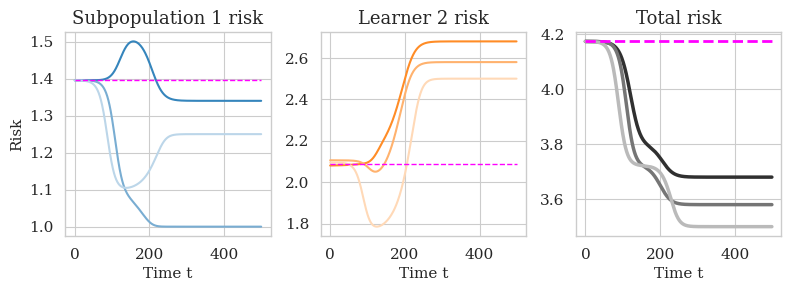

In [8]:

allocations = [None]*4 #<- select this to run experiments  with new random initial conditions
allocations = [
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([[0.486, 0.505, 0.503], [0.514, 0.495, 0.497]]),
               np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               ]  #<- select this to reproduce plots in the paper 
min_fn = quadratic_min #<- select this for noisy setting
#min_fn = quadratic_min #<- select this for noiseless updates from the learners 
#min_fn = gradient_step #<- select this for gradient descent updates from the learners
legend = False          
with context:
    fig, axs = plt.subplots(1,3, figsize = (8,3))
    for t in range(4):
        (average_risks_subpop, average_risks_learner, all_risks, _) = run_trial(allocations[t], min_fn, k = None)
        ls = '-'
        color_adj = 1
        c = None
        if t < 3:
            lw = 1.5
            if t == 0:
                color_adj = 0.1
                legend = False
            if t == 1:
                color_adj = 0.4
                legend = False
            if t ==2:
                color_adj = 0.7
                legend = True
        else: 
            lw = 1
            ls = '--'
            c = 'magenta'
            color_adj = 1
            legend = False
        legend = False
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, special_c=c, color_adj=color_adj, legend=legend, plot_learners=[1])
    plt.tight_layout()
    #plt.suptitle('Learners: Noiseless risk minimization wrt. subpop mixture. Subpopulations: MWUD wrt. learner risks', y=1.05, fontsize=14)
    
fig.savefig('risk_dynamics_0.pdf')

Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.504, 0.496]), array([0.489, 0.511]), array([0.502, 0.498])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]


Final Conditions:
		Learners decisions: [[0.315 0.5  ]
 [0.991 0.981]]
		Subpopulation allocations: [[1. 0.]
 [0. 1.]
 [1. 0.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([0.494, 0.506])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[0.322 0.503]
 [0.984 1.019]]
		Subpopulation allocations: [[1. 0.]
 [0. 1.]
 [1. 0.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.486, 0.514]), array([0.505, 0.495]), array([0.503, 0.497])]
Optimal decisions theta for each subpop (row-wise) [array([0, 1]), array([1, 1]), array([0.6, 0. ])]
Final Conditions:
		Learners decisions: [[ 0.801  0.52 ]
 [-0.005  0.986]]
		Subpopulation allocations: [[0. 1.]
 [1. 0.]
 [1. 0.]]
Initial Conditions:
There are 2 initial learners
Subpopulation spl

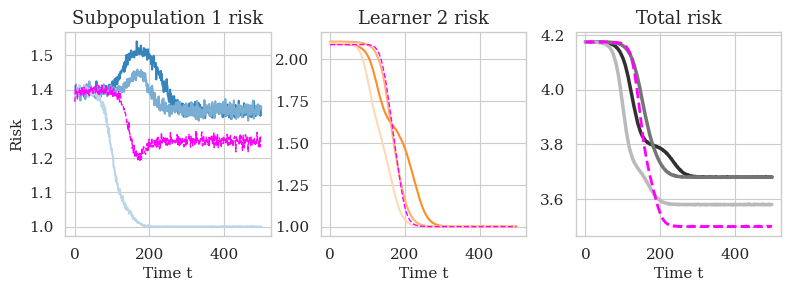

In [9]:

allocations = [None]*4 #<- select this to run experiments  with new random initial conditions
allocations = [
               np.array([ [0.504, 0.489, 0.502], [0.496, 0.511, 0.498]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([[0.486, 0.505, 0.503], [0.514, 0.495, 0.497]]),
               np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               ]  #<- select this to reproduce plots in the paper 
min_fn = noisy_quadratic_min #<- select this for noisy setting
          
with context:
    fig, axs = plt.subplots(1,3, figsize = (8,3))
    for t in range(4):
        (average_risks_subpop, average_risks_learner, all_risks, _) = run_trial(allocations[t], min_fn, k = None)
        ls = '-'
        color_adj = 1
        c = None
        if t < 3:
            lw = 1.5
            if t == 0:
                color_adj = 0.1
                legend = False
            if t == 1:
                color_adj = 0.4
                legend = False
            if t ==2:
                color_adj = 0.7
                legend = True
        else: 
            lw = 1
            ls = '--'
            c = 'magenta'
            color_adj = 1
            legend = False
        legend = False
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, special_c=c, color_adj=color_adj, legend=legend, plot_learners=[1])
    plt.tight_layout()
    #plt.suptitle('Learners: Noiseless risk minimization wrt. subpop mixture. Subpopulations: MWUD wrt. learner risks', y=1.05, fontsize=14)
    
fig.savefig('risk_dynamics_1.pdf')

Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.496, 0.504]), array([0.511, 0.489]), array([0.498, 0.502])]
Optimal decisions theta for each subpop (row-wise) [array([0.001, 1.   ]), array([1.001, 1.005]), array([0.592, 0.002])]
Final Conditions:
		Learners decisions: [[ 0.531  0.993]
 [ 0.648 -0.007]]
		Subpopulation allocations: [[1. 0.]
 [1. 0.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([0.494, 0.506])]
Optimal decisions theta for each subpop (row-wise) [array([0.006, 0.997]), array([0.997, 1.   ]), array([ 0.602, -0.004])]
Final Conditions:
		Learners decisions: [[0.05  0.942]
 [0.763 0.49 ]]
		Subpopulation allocations: [[1. 0.]
 [0. 1.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.486, 0.514]), array([0.505, 0.495]), arr

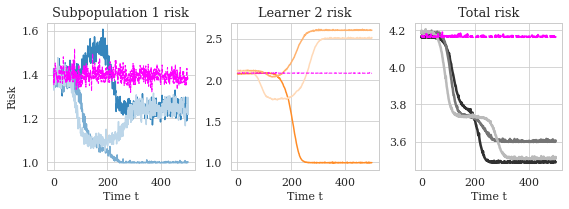

In [12]:

allocations = [None]*4 #<- select this to run experiments  with new random initial conditions
allocations = [
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([[0.486, 0.505, 0.503], [0.514, 0.495, 0.497]]),
               np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               ]  #<- select this to reproduce plots in the paper 
min_fn = quadratic_min #<- select this for noisy setting
          
with context:
    fig, axs = plt.subplots(1,3, figsize = (8,3))
    for t in range(4):
        (average_risks_subpop, average_risks_learner, all_risks, _) = run_trial(allocations[t], min_fn, k = 100000, sample_size=1000)
        ls = '-'
        color_adj = 1
        c = None
        if t < 3:
            lw = 1.5
            if t == 0:
                color_adj = 0.1
                legend = False
            if t == 1:
                color_adj = 0.4
                legend = False
            if t ==2:
                color_adj = 0.7
                legend = True
        else: 
            lw = 1
            ls = '--'
            c = 'magenta'
            color_adj = 1
            legend = False
        legend = False
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, special_c=c, color_adj=color_adj, legend=legend, plot_learners=[1])
    plt.tight_layout()
    #plt.suptitle('Learners: Noiseless risk minimization wrt. subpop mixture. Subpopulations: MWUD wrt. learner risks', y=1.05, fontsize=14)
    
fig.savefig('risk_dynamics_2.pdf')

Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.496, 0.504]), array([0.511, 0.489]), array([0.498, 0.502])]
Optimal decisions theta for each subpop (row-wise) [array([0.006, 1.005]), array([0.999, 1.   ]), array([0.605, 0.   ])]
Final Conditions:
		Learners decisions: [[ 0.856  0.499]
 [-0.006  0.965]]
		Subpopulation allocations: [[0. 1.]
 [1. 0.]
 [1. 0.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.501, 0.499]), array([0.491, 0.509]), array([0.494, 0.506])]
Optimal decisions theta for each subpop (row-wise) [array([0.004, 0.997]), array([1.004, 1.003]), array([ 0.606, -0.004])]
Final Conditions:
		Learners decisions: [[-0.047  1.028]
 [ 0.786  0.469]]
		Subpopulation allocations: [[1. 0.]
 [0. 1.]
 [0. 1.]]
Initial Conditions:
There are 2 initial learners
Subpopulation splits: [1, 1, 1]
Initial allocations: [array([0.514, 0.486]), array([0.495, 0.505]),

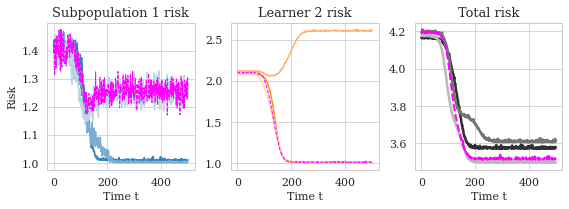

In [14]:
allocations = [None]*4 #<- select this to run experiments  with new random initial conditions
allocations = [
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([ [0.514, 0.495, 0.497], [0.486, 0.505, 0.503]]),
               np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               ]  #<- select this to reproduce plots in the paper 
min_fn = noisy_quadratic_min #<- select this for noisy setting
          
with context:
    fig, axs = plt.subplots(1,3, figsize = (8,3))
    for t in range(4):
        (average_risks_subpop, average_risks_learner, all_risks, _) = run_trial(allocations[t], min_fn, k = 100000, sample_size=1000)
        ls = '-'
        c = None
        color_adj = 1
        if t < 3:
            lw = 1.5
            if t == 0:
                color_adj = 0.1
                legend = False
            if t == 1:
                color_adj = 0.4
                legend = False
            if t ==2:
                color_adj = 0.7
                legend = True
        else: 
            lw = 1
            ls = '--'
            c = 'magenta'
            color_adj = 1
            legend = False
        legend = False
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, special_c=c, color_adj=color_adj, legend=legend, plot_learners=[1])
    plt.tight_layout()
    #plt.suptitle('Learners: Noiseless risk minimization wrt. subpop mixture. Subpopulations: MWUD wrt. learner risks', y=1.05, fontsize=14)
    
fig.savefig('risk_dynamics_3.pdf')

Increasing temperature

In [ ]:
allocations = [None]*4 #<- select this to run experiments  with new random initial conditions
allocations = [
               np.array([[0.496, 0.511, 0.498], [0.504, 0.489, 0.502]]),
               np.array([[0.501, 0.491, 0.494], [0.499, 0.509, 0.506]]),
               np.array([ [0.514, 0.495, 0.497], [0.486, 0.505, 0.503]]),
               np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
               ]  #<- select this to reproduce plots in the paper 
min_fn = quadratic_min #<- select this for noisy setting
          
with context:
    fig, axs = plt.subplots(1,3, figsize = (8,3))
    for t in range(4):
        (average_risks_subpop, average_risks_learner, all_risks, all_alphas) = run_trial(allocations[t], min_fn, k = 100000, sample_size=1000, temp=0.1, T=500)
        ls = '-'
        c = None
        color_adj = 1
        if t < 3:
            lw = 1.5
            if t == 0:
                color_adj = 0.1
                legend = False
            if t == 1:
                color_adj = 0.4
                legend = False
            if t ==2:
                color_adj = 0.7
                legend = True
        else: 
            lw = 1
            ls = '--'
            c = 'magenta'
            color_adj = 1
            legend = False
        legend = False
        plot_experiment(average_risks_subpop, average_risks_learner, all_risks, axs, ls=ls, lw = lw, special_c=c, color_adj=color_adj, legend=legend, plot_learners=[1])
    plt.tight_layout()



In [ ]:
allocations = np.array([[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]])
min_fn = quadratic_min #<- select this for noisy setting
(average_risks_subpop, average_risks_learner, all_risks, all_alphas) = run_trial(allocations, min_fn, k = 10000, sample_size=None, temp=0.1, T=10, shared_sample=False)
all_alphas

In [ ]:
sns.lineplot(data = all_alphas[0][:,0], label = 'Learner 1')

# each learner gets samples according to a multinomial distribution

## Increased competition experiments

In [10]:
def run_competition_experiment(T, subpops, n_learners_max=None, min_fn=noisy_quadratic_min):
    n_learners_init = len(subpops[0].alphas)
    if n_learners_max is None:
        n_learners_max = len(subpops)
    print("Initial Conditions:")
    print(f"There are {n_learners_init} initial learners")
    exp_out = run_experiment(T, subpops, rr=False, early_stop=True, verbose=False, min_fn = min_fn)
    average_risks_subpop, average_risks_learner, all_risks, all_thetas, all_alphas = exp_out
    total_average_risks_subpop_over_time = {-1: average_risks_subpop}
    for i in range(n_learners_max - n_learners_init):
        for subpop in subpops:
            subpop.break_learner(i)
        exp_out = run_experiment(T, subpops, rr=False, early_stop=True, verbose=False, min_fn = min_fn)  
        total_average_risks_subpop_over_time[i] = exp_out[0]
    return(total_average_risks_subpop_over_time)

In [11]:
seed = 0
rng = np.random.default_rng(seed)
T = 10000
n_subpops = 50
n_learners_init = 2
d = 8
# relative sizes
beta = 1
# initial allocations
dist = rng.random(size=(n_learners_init,n_subpops))*0.0001
alpha = np.ones(shape=(n_learners_init,n_subpops)) + dist
# alpha_ij <- fraction of subpop j going to learner i
alpha =  normalize(alpha, axis=0, norm='l1')

# optimal thetas for each subpop
phi = rng.normal(size=(n_subpops, d))
subpops = [QuadraticSubPop(phi[i,:], beta, alpha[:,i]) for i in range(n_subpops)]

In [12]:
res = run_competition_experiment(T, subpops, n_learners_max=None, min_fn=noisy_quadratic_min)

Initial Conditions:
There are 2 initial learners


KeyboardInterrupt: 

In [ ]:
average_res= {k:np.mean(np.array(v), 1) for k, v in res.items()}
subpop_equilibrium_res = {k:v[-1] for k, v in res.items()}
average_equilibrium_res= {k:v[0] for k, v in average_res.items()}
break_times = {k:len(v) for k, v in average_res.items()}
break_times = np.cumsum(list(break_times.values()))

In [ ]:
selected_subpops = range(50) #<- choose different subpopulations to plot the risk of alongside with total average risk.
with context:
    fig, axs = plt.subplots(1,2, figsize = (12,3))
    axs[0].plot(n_subpops*np.concatenate((list(average_res.values()))), c='k', lw =3, label = 'Total Risk')
    for i, bt in enumerate(break_times):
        if i == 0:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 2.5, label='Learners split')
        else:
            axs[0].axvline(x =bt, alpha = 0.9, ls = '--', lw = 1.5)
    axs[0].legend(loc = 1)
    axs[0].set_xlim([0, 1800])
    eq_risks = np.array(list(subpop_equilibrium_res.values()))
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), eq_risks[:,selected_subpops], label ='Subpop')
    axs[1].plot(range(n_learners_init, n_learners_init+len(eq_risks)), 
                list(average_equilibrium_res.values()), c='k', lw =3, label = 'Average Risk')
    axs[1].legend()
    axs[1].set_xlim([2, 20])
    axs[0].set_xlabel('Time t')
    axs[1].set_xlabel('Number of learners')
    axs[0].set_ylabel('Risk')
    axs[1].set_ylabel('Risk at equilibrium')
    axs[0].set_title('Total risk over time')
    axs[1].set_title('Risks reduction with number of learners')
    h, l = axs[1].get_legend_handles_labels()
    axs[1].legend(h, ['Subpop 1', 'Subpop 2', 'Subpop 3', 'Average Risk'])
    plt.tight_layout()
    fig.savefig('competition.pdf')

## Census Data

In [ ]:
features, label, data = generate_folktables_data()

In [ ]:
# convert dataframes to numpy arrays
features = np.nan_to_num(np.array(features),0)
label = np.nan_to_num(np.array(label),0).flatten()
group = np.nan_to_num(np.array(group),0).flatten()

In [ ]:
# Generate allocations
n_subpops = len(np.unique(group))
n_learners = 3
allocation = 1+0.1*np.random.randn(n_subpops, n_learners)
allocation = normalize(allocation, axis=1, norm='l1') 

# Instantiate the subpopulations
subpops = []
for i,g in enumerate(np.unique(group)):
    g_inds = group==g
    g_beta = np.sum(g_inds) / len(group)
    print(f'Share of subpopulation {g}: {100*g_beta:.3f}%')
    subpops.append(EmpiricalSubPop(features[g_inds], label[g_inds], g_beta, allocation[i]))

In [ ]:
# Run the retention dynamics
T=10000
min_fn = quadratic_min
verbose = True
early_stop = False
n_learners = len(subpops[0].alphas)
if verbose:
    print("Initial Conditions:")
    print(f"There are {n_learners} initial learners")
    print(f"Subpopulation splits: {[s.beta for s in subpops]}")
    print(f"Initial allocations: {[s.alphas for s in subpops]}")
    print(f"Optimal decisions theta for each subpop (row-wise) {[s.phi for s in subpops]}")
average_risks_subpop = []
average_risks_learner = []
all_risks = []
all_thetas = []
all_alphas = []
for t in range(T):
    thetas = np.array(learner_decisions(subpops))
    all_thetas.append(thetas)
    alpha = subpop_decisions(thetas, subpops, epsilon=0.999)
    all_alphas.append(alpha.T)
    risks = get_all_risks(thetas, subpops)
    all_risks.append(risks)
    a_risk_subpop = average_risk_subpop(thetas, subpops)
    average_risks_subpop.append(a_risk_subpop)
    a_risk_learner = average_risk_learner(thetas, subpops)
    average_risks_learner.append(a_risk_learner)
    if early_stop:
        c_counts = convergent_count(subpops)
        if min(c_counts) > 20:
            print(f'Stopping early: Reached convergence by time {t}')
            break
if verbose:
    print("Final Conditions:")
    print(f'\t\tLearners decisions: {thetas}')
    print(f'\t\tSubpopulation allocations: {alpha}')

### Risk of subpopulation and learnears over time

In [ ]:
# compute relative risk for subpopulations
best_risks = []
betas = []
for i in range(len(subpops)):
    best_risks.append(subpops[i].risk(subpops[i].phi))
    betas.append(subpops[i].beta)

relative_risks_subpop = []
for i in range(len(average_risks_subpop)):
    relative_risks_subpop.append(100*((average_risks_subpop[i]/betas)/(best_risks) - 1))

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (13,4), gridspec_kw={'width_ratios':[1,0.8, 0.5], 'wspace': 0.1})
plot_experiment(relative_risks_subpop, average_risks_learner, all_risks, axs,
               plot_learners=3, plot_subpop=8)
for i,ax in enumerate(axs):
    ax.set_xlim(0,25)
    ax.tick_params(axis='y', which='major', pad=-4)
    ax.set_ylabel('')
    if i <= 1:
        ax.legend()
    if i == 0:
        #ax.set_ylabel('Relative Risk (%)')
        ax.set_title('Relative Subpopulation risks over time (%)')
    if i== 2:
        ax.set_yticks([])
        ax.set_ylabel('')
fig.savefig('census_loss.pdf')

### Ternary plot of allocation dynamics

In [ ]:
df_full = pd.DataFrame(columns = ['Learner 1', 'Learner 2', 'Learner 3', 'Subpopulation', 'Step'])
for i in range(len(all_alphas)):
    df = pd.DataFrame(all_alphas[i].T, columns = ['Learner 1', 'Learner 2', 'Learner 3'])
    df['Subpopulation'] = range(8)
    df['Step'] = i
    df_full = pd.concat([df_full, df])
df_full['Size'] = 0.1

In [ ]:
fig = px.scatter_ternary(df_full, size_max = 5, opacity = 0.8,
                         a="Learner 1", b="Learner 2", c="Learner 3", color = "Subpopulation")
fig.show()